# Slicing circuits using ``qiskit_addon_utils.slicing``

Qiskit loosely describes [layers](https://docs.quantum.ibm.com/api/qiskit/qiskit.dagcircuit.DAGCircuit) as being depth-1 partitions of the circuit across all qubits. Some Qiskit addons make use of the term **slices** to describe layers of arbitrary depth. More concretely, slices can be defined as time-like partitions of a [QuantumCircuit](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit) which span all qubits. Similar to layers, composing all slices of a `QuantumCircuit` produces a circuit which is semantically equivalent to the original.

The [qiskit_addon_utils.slicing](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.slicing.html) module provides a few utilities for partitioning ``QuantumCircuit``s into slices. This is for example useful for [operator backpropagation](https://github.com/qiskit/qiskit-addon-obp/) We will give an overview of those tools in this guide.

**Note:** Throughout this guide, we will slice the circuit and use [qiskit_addon_utils.slicing.combine_slices](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.slicing.combine_slices.html) to recombine the slices with barriers to make it easier to visualize the slices.

First, we'll create a circuit from which we'll create slices.

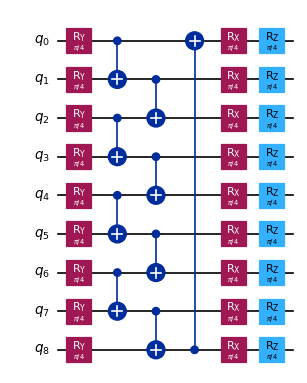

In [1]:
import numpy as np
from qiskit import QuantumCircuit

num_qubits = 9
qc = QuantumCircuit(num_qubits)
qc.ry(np.pi / 4, range(num_qubits))
qubits_1 = [i for i in range(num_qubits) if i % 2 == 0]
qubits_2 = [i for i in range(num_qubits) if i % 2 == 1]
qc.cx(qubits_1[:-1], qubits_2)
qc.cx(qubits_2, qubits_1[1:])
qc.cx(qubits_1[-1], qubits_1[0])
qc.rx(np.pi / 4, range(num_qubits))
qc.rz(np.pi / 4, range(num_qubits))
qc.draw("mpl", scale=0.6)

In the case where there is no clear way to exploit the structure of the circuit for back-propagation, a user may wish to simply partition their circuit into slices of a given depth. Here, we'll separate this circuit into depth-1 slices.

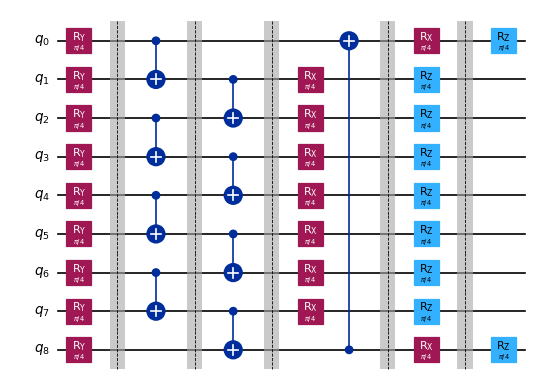

In [2]:
from qiskit_addon_utils.slicing import combine_slices, slice_by_depth

slices = slice_by_depth(qc, 1)
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

Now let's try depth-2.

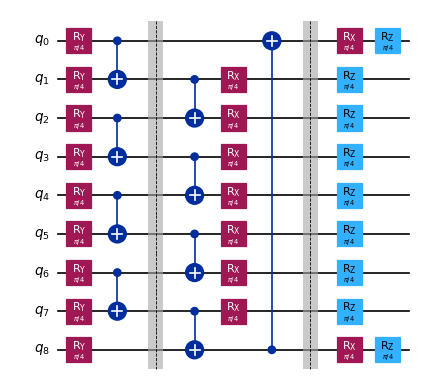

In [3]:
slices = slice_by_depth(qc, 2)
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

In many cases, such as Trotter circuits, it may be advantageous to slice by gate type. Slices holding a given gate type will be further split out into depth-1 slices, as there is little downside in doing so.

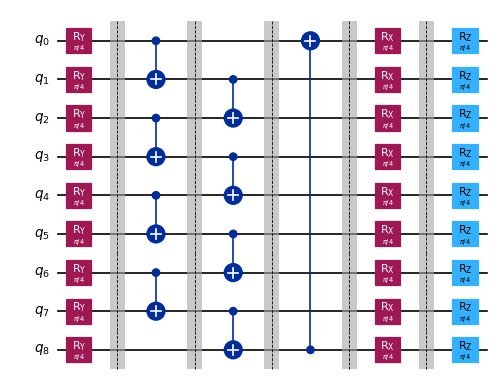

In [4]:
from qiskit_addon_utils.slicing import slice_by_gate_types

slices = slice_by_gate_types(qc)
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

If your circuit was designed to exploit the physical qubit connectivity, you may want to create slices based on an edge coloring. Here, we will assign a 3-coloring to the circuit edges and slice the circuit with respect to the edge coloring. This only affects non-local gates. Single qubit gates will be added to their own slices by gate type.

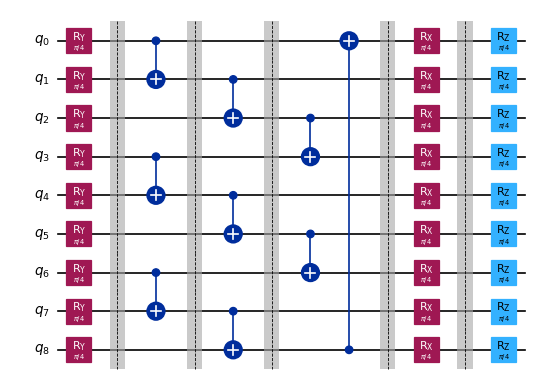

In [5]:
from qiskit_addon_utils.slicing import slice_by_coloring

# Assign a color to each set of connected qubits
coloring = {}
for i in range(num_qubits - 1):
    coloring[(i, i + 1)] = i % 3
coloring[(num_qubits - 1, 0)] = 2

# Create a circuit with operations added in order of color
qc = QuantumCircuit(num_qubits)
qc.ry(np.pi / 4, range(num_qubits))
edges = [edge for color in range(3) for edge in coloring if coloring[edge] == color]
for edge in edges:
    qc.cx(edge[0], edge[1])
qc.rx(np.pi / 4, range(num_qubits))
qc.rz(np.pi / 4, range(num_qubits))

# Create slices by edge color
slices = slice_by_coloring(qc, coloring=coloring)
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

For more custom slicing strategies a user may wish to place barriers in the locations they want to slice and use the [slice_by_barriers](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.slicing.slice_by_barriers.html) function. Here, we will create 3 slices, one for each rotation layer and one for the entangling layer.

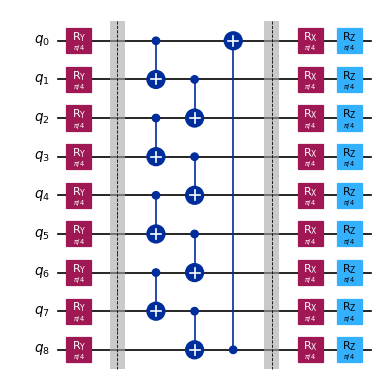

In [6]:
qc = QuantumCircuit(num_qubits)
qc.ry(np.pi / 4, range(num_qubits))
qc.barrier()
qubits_1 = [i for i in range(num_qubits) if i % 2 == 0]
qubits_2 = [i for i in range(num_qubits) if i % 2 == 1]
qc.cx(qubits_1[:-1], qubits_2)
qc.cx(qubits_2, qubits_1[1:])
qc.cx(qubits_1[-1], qubits_1[0])
qc.barrier()
qc.rx(np.pi / 4, range(num_qubits))
qc.rz(np.pi / 4, range(num_qubits))
qc.draw("mpl", scale=0.6)

We will not draw the re-combined slices as a single circuit since it would look identical to the input circuit. Instead, below we draw each slice on its own.

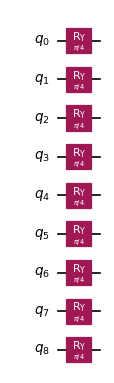

In [7]:
from qiskit_addon_utils.slicing import slice_by_barriers

slices = slice_by_barriers(qc)
slices[0].draw("mpl", scale=0.6)

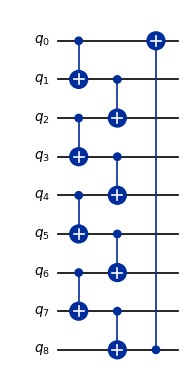

In [8]:
slices[1].draw("mpl", scale=0.6)

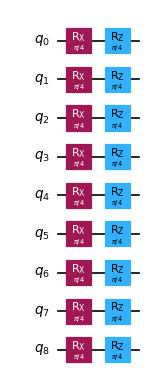

In [9]:
slices[2].draw("mpl", scale=0.6)